# 暂退法（Dropout）

我们实现 `dropout_layer` 函数，
该函数以`dropout`的概率丢弃张量输入`X`中的元素

In [11]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float().to('cuda')
    return mask * X / (1.0 - dropout)

测试`dropout_layer`函数

In [2]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  0.,  0.,  0., 12., 14.],
        [ 0.,  0.,  0., 22., 24.,  0.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元

In [13]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1).to('cuda')
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2).to('cuda')
        self.lin3 = nn.Linear(num_hiddens2, num_outputs).to('cuda')
        self.relu = nn.ReLU().to('cuda')

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

训练和测试

In [15]:
from d2l.torch import Accumulator, Animator, accuracy

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to('cuda'), y.to('cuda')
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        X, y = X.to('cuda'), y.to('cuda')
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

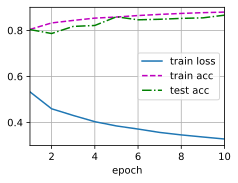

In [16]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

简洁实现

In [17]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
net = net.to('cuda')

对模型进行训练和测试

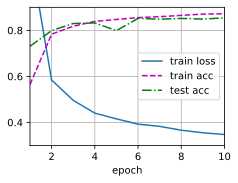

In [18]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 练习

1. 交换两个暂退层

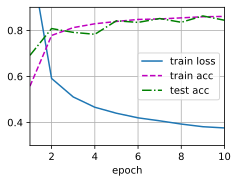

In [19]:
dropout1, dropout2 = 0.5, 0.2

net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
net = net.to('cuda')

trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

2. 增加训练轮数至50

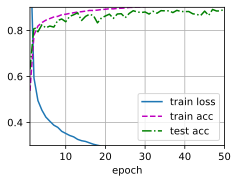

In [20]:
dropout1, dropout2 = 0.2, 0.5
num_epochs = 50

net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
net = net.to('cuda')

trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

不使用暂退法

AssertionError: nan

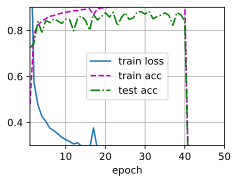

In [21]:
dropout1, dropout2 = 0, 0
num_epochs = 50

net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
net = net.to('cuda')

trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

结论：不使用暂退法会导致过拟合。

5. 同时使用暂退法和权重衰减

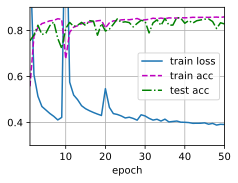

In [25]:
dropout1, dropout2 = 0.2, 0.5
num_epochs = 50

net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
net = net.to('cuda')

trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.001)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

单独使用权重衰减

AssertionError: 0.9075955113728841

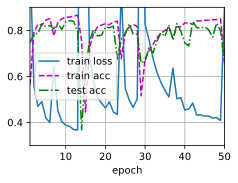

In [26]:
dropout1, dropout2 = 0, 0
num_epochs = 50

net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
net = net.to('cuda')

trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.001)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

结论：单独使用暂退法 优于 同时使用暂退法和权重衰减 优于 单独使用权重衰退 优于 什么都不用

6. 将暂退法应用到权重矩阵的各个权重，而不是激活值

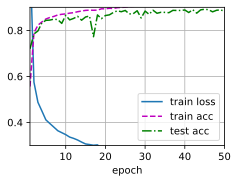

In [27]:
dropout1, dropout2 = 0.2, 0.5
num_epochs = 50

net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.Dropout(dropout1),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.Dropout(dropout2),
        nn.ReLU(),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
net = net.to('cuda')

trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

3. 当应用或不应用暂退法时，每个隐藏层中激活值的方差是多少？绘制一个曲线图，以显示这两个模型的每个隐藏层中激活值的方差是如何随时间变化的。

In [45]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1).to('cuda')
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2).to('cuda')
        self.lin3 = nn.Linear(num_hiddens2, num_outputs).to('cuda')
        self.relu = nn.ReLU().to('cuda')


    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        self.var1 = H1.detach().var()
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        self.var2 = H2.detach().var()
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

In [48]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0., 1.], figsize=(7,5),
                        legend=['train loss', 'train acc', 'test acc', 'variant 1', 'variant 2'],
                        fmts=('-', 'm--', 'g-.', 'r:', 'c:'))
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc, net.var1.to('cpu'), net.var2.to('cpu')))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

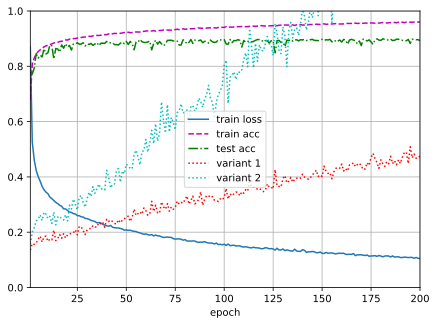

In [52]:
num_epochs = 200
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

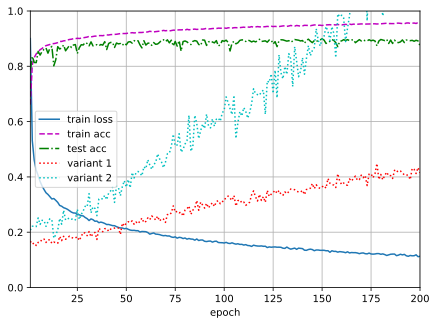

In [57]:
num_epochs = 200
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=False)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)